# My First Neural Network
After finishing a few of the great courses provided here on [kaggle/learn](https://www.kaggle.com/learn/overview), I decided to build my first NN model using this dataset. <BR>
The mission is to predict bone age using hand X-ray images and their associated age (in months).
<BR>
<BR>
I hope this notebook will provide a guideline for other beginners like me as they do their first steps in building NN models

# Project Setup
### Imports and Hiperparameters
I decided to gather all the used modules in one cell to provide a better understanding of the project and to maintain order.

In [1]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.metrics import mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [2]:
# Hiper parameters
img_rows, img_cols = 128, 128 # 384, 384
image_size = (img_rows, img_cols)
train_batch_size = 32
valid_batch_size = 256
EPOCHS = 100
STEPS_PER_EPOCH = lambda X: (0.8*len(X)) // train_batch_size #0.8 is a set parameter also
VALIDATION_STEPS = lambda y: (0.2*len(y)) // valid_batch_size #0.2 is a set parameter also

### Reading the Data Files
The data provided in this project includes train images and their associated csv file (containing the bonage for each image) and also test images without their associated csv file. <BR>
The reason for that is because the way Kaggle competitions work - you need to submit a csv containing your predictions for the test data to get your prediction score.
<BR>
Due to the fact that the competition was already closed when I decided to work on this project, I  evaluated my results on my own using the test csv file found [here](https://stanfordmedicine.app.box.com/s/4r1zwio6z6lrzk7zw[](http://)3fro7ql5mnoupcv).

In [3]:
data_file = "../input/rsna-bone-age/boneage-training-dataset.csv"
test_file = "../input/bone-age-ground-truth-csv/Bone age ground truth.csv"
data_dir = '../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
test_dir = "../input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset"

all_data = pd.read_csv(data_file, dtype=str)

# Loading test data in the same format as all data
all_test = pd.read_csv(test_file, dtype=str,
                       names=['id', 'male', 'boneage'],
                       header=0)

# Creating a path column to correclty load the images using ImageDataGenerator
all_data['path'] = ["{}.png".format(i) for i in all_data['id']]
all_test['path'] = ["{}.png".format(i) for i in all_test['id']]

all_data.head()

,id,boneage,male,path
0,1377,180,False,1377.png
1,1378,12,False,1378.png
2,1379,94,False,1379.png
3,1380,120,True,1380.png
4,1381,82,False,1381.png


In [4]:
# As customary, splitting the data into train and validation sets
train, valid = train_test_split(all_data, test_size=0.2, random_state=42)

### Creating Image Data Generators

Keras’ ImageDataGenerator class is a class used to augment data and create batches from it. <BR>
The class’ constructor accepts many augmentation arguments you can read about [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe). <BR>
I used those augmentation arguments to create the following generators:
* data_generator - used for training, data is augmented so the model will learn various versions of possible bone images.
* valid_generator - used for validation, data is **not** augmented so validation set evaluation will be similar to the test set evaluation.
* test_generator - used for testing, never should be augmented.
<BR>
<BR>
All of the mentioned generators are processed with the same preprocess function (and thus are in the same format)

In [5]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True,
                                    validation_split=0.2,
                                    fill_mode='nearest')

valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

Using those generators, we create objects from the 'flow_from_dataframe' method. <BR>
This method creates an iterator that iterates over the data in batches (determined by 'batch_size' argument) and returns both the images and their associated boneage. <BR>
I recommend reading more about this method and the ImageDataGenerator class entirely.

In [6]:
train_gen = data_generator.flow_from_dataframe(
    dataframe=train,
    directory=data_dir,
    x_col='path',
    y_col='boneage',
    target_size=image_size,
    color_mode='rgb',
    class_mode='sparse',
    batch_size=train_batch_size,
    shuffle=True,
    seed=42,
    interpolation='nearest',
    validate_filenames=True)

valid_gen = valid_generator.flow_from_dataframe(
    dataframe=valid,
    directory=data_dir,
    x_col='path',
    y_col='boneage',
    target_size=image_size,
    color_mode='rgb',
    class_mode='sparse',
    batch_size=valid_batch_size,
    shuffle=True,
    seed=42,
    interpolation='nearest',
    validate_filenames=True)

test_gen = test_generator.flow_from_dataframe(
    dataframe=all_test,
    directory=test_dir,
    x_col='path',
    y_col='boneage',
    target_size=image_size,
    color_mode='rgb',
    classes=None,
    class_mode='sparse',
    batch_size=200,
    shuffle=False,
    seed=42,
    interpolation='nearest',
    validate_filenames=True)

Found 10088 validated image filenames belonging to 154 classes.
Found 2523 validated image filenames belonging to 91 classes.
Found 200 validated image filenames belonging to 196 classes.


# Viewing Some Images

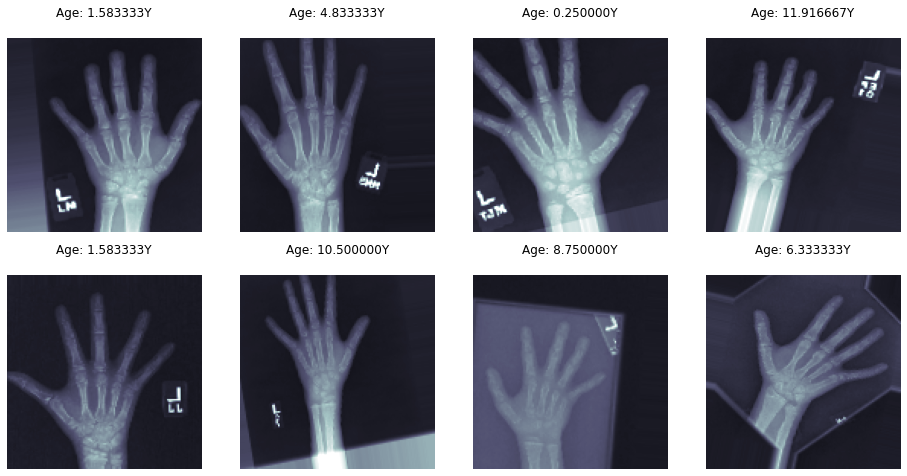

In [7]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize=(16, 8))
for (c_x, c_y, c_ax, ind) in zip(t_x, t_y, m_axs.flatten(), range(8)):
    c_ax.imshow(c_x[:,:,0], cmap='bone', vmin=-127, vmax=127)
    c_ax.set_title('Age: %fY\n' % (t_y[ind]/12.0))
    c_ax.axis('off')

# Model Creation

As I learned from the DL course and after a lot of experiments with hiperparameters and layer construction, this is the best model, regarding test results, in the computational limit provided by kaggle, I could achieve:

In [8]:
model = Sequential()

# Input Layer
model.add(Conv2D(16, kernel_size=(7,7), strides=(2,2), activation='relu', input_shape=(img_rows, img_cols, 3)))
model.add(Dropout(0.25))

# Convulotional Layers
model.add(Conv2D(32, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Dense Layer
model.add(Dense(256, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', 
              loss='mse',
              metrics=['mae'])

In [9]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 10,
                              verbose=0, 
                              mode='auto')

#model checkpoint
mc = ModelCheckpoint('best_model.h5', 
                     monitor='val_loss', 
                     mode='min', 
                     save_best_only=True)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', 
                                factor=0.1, 
                                patience=5, 
                                verbose=0, 
                                mode='min', 
                                min_delta=0.0001, 
                                cooldown=0, 
                                min_lr=0)

CALLBACKS = [early_stopping, mc, red_lr_plat]


In [10]:
#fit the model
history = model.fit_generator(train_gen,
    steps_per_epoch = STEPS_PER_EPOCH(all_data),
    validation_data = valid_gen,
    validation_steps = VALIDATION_STEPS(all_data),
    epochs = EPOCHS,
    callbacks = CALLBACKS)

history

Epoch 1/100
315/315 [==============================] - 581s 2s/step - loss: 33505.6094 - mae: 75.8550 - val_loss: 2338.3364 - val_mae: 41.0264
Epoch 2/100
315/315 [==============================] - 514s 2s/step - loss: 6017.0400 - mae: 63.5120 - val_loss: 706.2062 - val_mae: 20.8935
Epoch 3/100
315/315 [==============================] - 510s 2s/step - loss: 2150.9026 - mae: 37.8351 - val_loss: 782.0948 - val_mae: 20.7171
Epoch 4/100
315/315 [==============================] - 513s 2s/step - loss: 2129.7720 - mae: 37.6738 - val_loss: 735.0241 - val_mae: 20.3533
Epoch 5/100
315/315 [==============================] - 510s 2s/step - loss: 2104.1384 - mae: 37.4872 - val_loss: 685.2977 - val_mae: 20.4194
Epoch 6/100
315/315 [==============================] - 510s 2s/step - loss: 2091.9060 - mae: 37.4400 - val_loss: 745.8606 - val_mae: 20.6274
Epoch 7/100
315/315 [==============================] - 509s 2s/step - loss: 2083.1089 - mae: 37.3680 - val_loss: 1034.7277 - val_mae: 23.7961
Epoch 8/10

# Results & Model Evalutaion

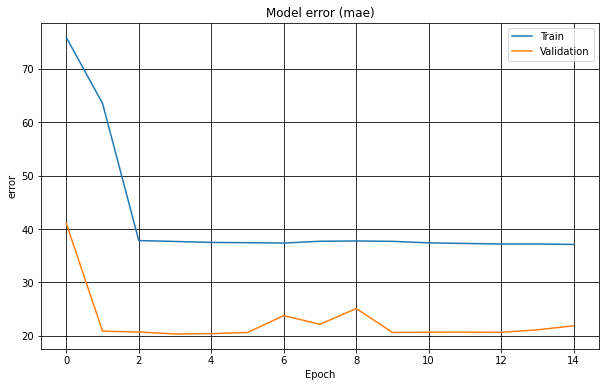

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(history.history['mae'])
ax.plot(history.history['val_mae'])
plt.title('Model error (mae)')
plt.ylabel('error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
ax.grid(color='black')
plt.show()
fig.savefig('train_validation_loss_graph', dpi=300)

In [12]:
# Loading the best model (saved with the checkpoint callback)
model.load_weights('best_model.h5')

In [13]:
# Test data evaluation regarding the loss and metric functions defined in the model (mae in our case).
model.evaluate(test_gen)

1/1 [==============================] - 0s 2ms/step - loss: 7475.0225 - mae: 71.1734


[7475.0224609375, 71.17341613769531]

8/8 [==============================] - 0s 57ms/step


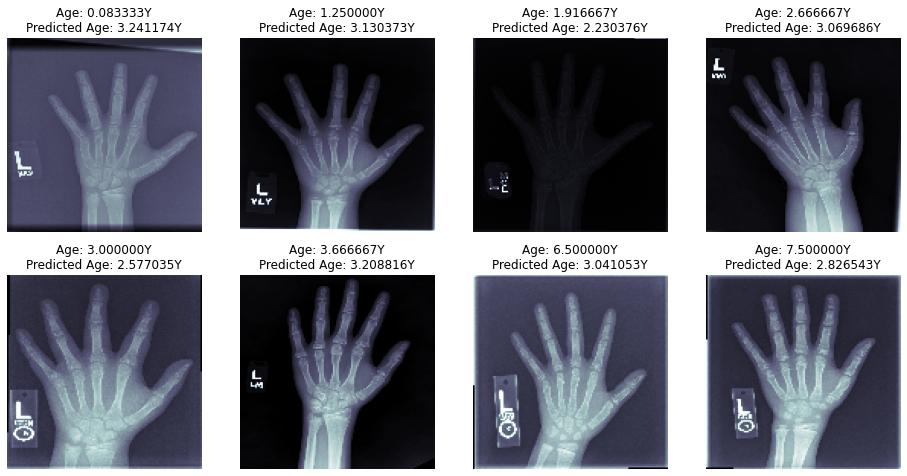

In [14]:
# Viewing some test images with their true and predicted images

test_X, test_Y = next(valid_gen)
pred = model.predict(test_X, verbose=True)
test_months = test_Y

ord_ind = np.argsort(test_Y)
ord_ind = ord_ind[np.linspace(0, len(ord_ind)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for (ind, ax) in zip(ord_ind, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap='bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months[ind]/12.0, 
                                                           pred[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi=300)

# Future Work

This project can be massively improved with

* Higher resolution images (I used 128x128 due to computational limitations).
* Better data sampling for training and validation (the classes are not balanced among train and valid sets).
* Data normalization - both rescaling the pixels and normalizing the 'boneage' data.
* Using pretrained models - like the other notebooks working on this dataset did.
* Improving layers construction - adding maxpooling methods and such.

# Conclusions
After spending many hours deciding which model design benfits the best results, I concluded that with the computation and time limit in Kaggle, my model is'nt going to reach very good results. <BR>
However, building this model was a challenging experience that taught me a lot about DL and NN models.
<BR> I definitely recommend this dataset and mission for beginners trying out their first NN.